In [1]:
import pandas as pd 
df = pd.read_csv('../data/processed/credit_risk_dataset.csv')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
1,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
2,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
3,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
4,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2


In [2]:
df['loan_status'] = df['loan_status'].replace({0:'non_defualt', 1:'defualt'})
for i in df.columns:
    if df[i].dtype == 'object':
        df[i] = df[i].astype('category')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28632 entries, 0 to 28631
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   person_age                  28632 non-null  int64   
 1   person_income               28632 non-null  int64   
 2   person_home_ownership       28632 non-null  category
 3   person_emp_length           28632 non-null  float64 
 4   loan_intent                 28632 non-null  category
 5   loan_grade                  28632 non-null  category
 6   loan_amnt                   28632 non-null  int64   
 7   loan_int_rate               28632 non-null  float64 
 8   loan_status                 28632 non-null  category
 9   loan_percent_income         28632 non-null  float64 
 10  cb_person_default_on_file   28632 non-null  category
 11  cb_person_cred_hist_length  28632 non-null  int64   
dtypes: category(5), float64(3), int64(4)
memory usage: 1.7 MB


In [5]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,non_defualt,0.10,N,2
1,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,defualt,0.57,N,3
2,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,defualt,0.53,N,2
3,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,defualt,0.55,Y,4
4,21,9900,OWN,2.0,VENTURE,A,2500,7.14,defualt,0.25,N,2


### both ANOVA and Eta Squared (η²) are sensitive to outliers,

In [25]:
def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    # df[col] = df[col].clip(lower=lower, upper=upper)
    return df[(df[col]>=lower) & (df[col] <= upper)]


In [26]:
clean_df = df.copy()
num_cols = [
    'person_age', 'person_income', 'person_emp_length',
    'loan_amnt', 'loan_int_rate',
    'loan_percent_income', 'cb_person_cred_hist_length'
]
for col in num_cols:
    clean_df = remove_outliers_iqr(clean_df, col)
    print(len(clean_df))

27338
26120
25557
24444
24434
23814
23075


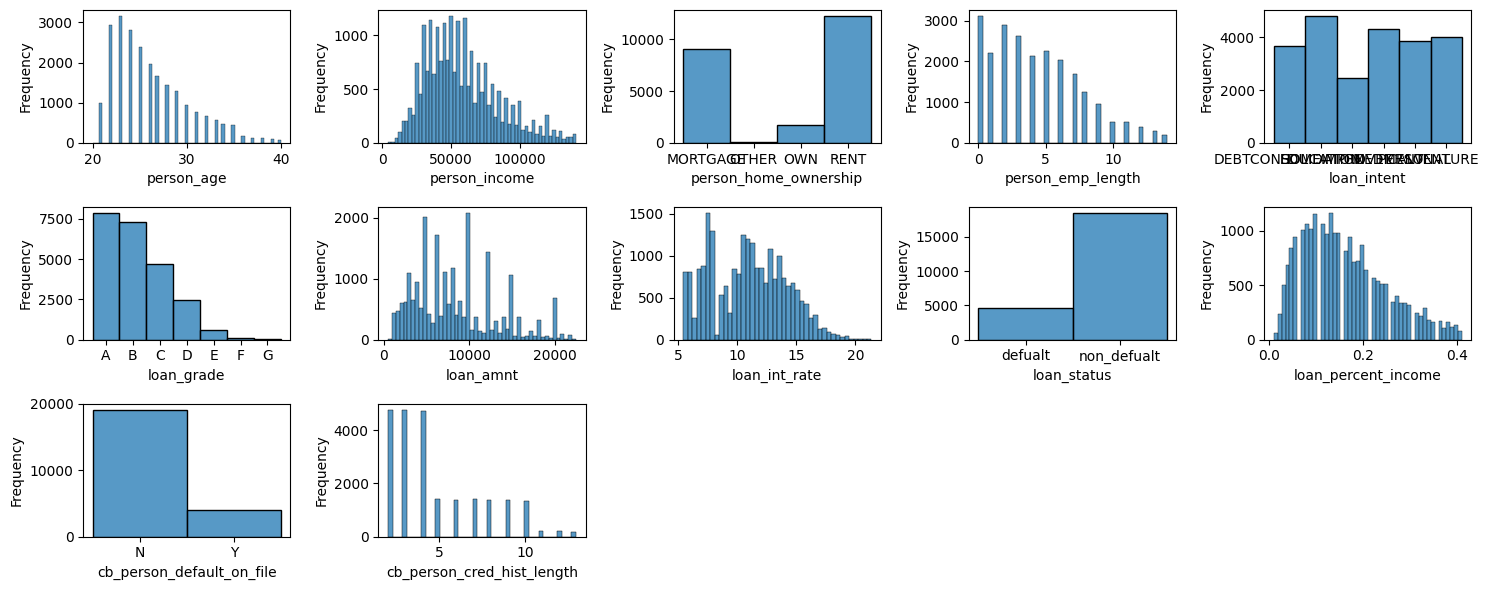

In [15]:
import matplotlib.pyplot as plt 
import seaborn as sns

fig, axes = plt.subplots(len(clean_df.columns)//4, 5, figsize=(15, 6))
axes = axes.flatten()
for i, col in enumerate(clean_df.columns):
    # if clean_df[col].dtype != 'category':
    sns.histplot(clean_df[col], ax=axes[i])
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")
    
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

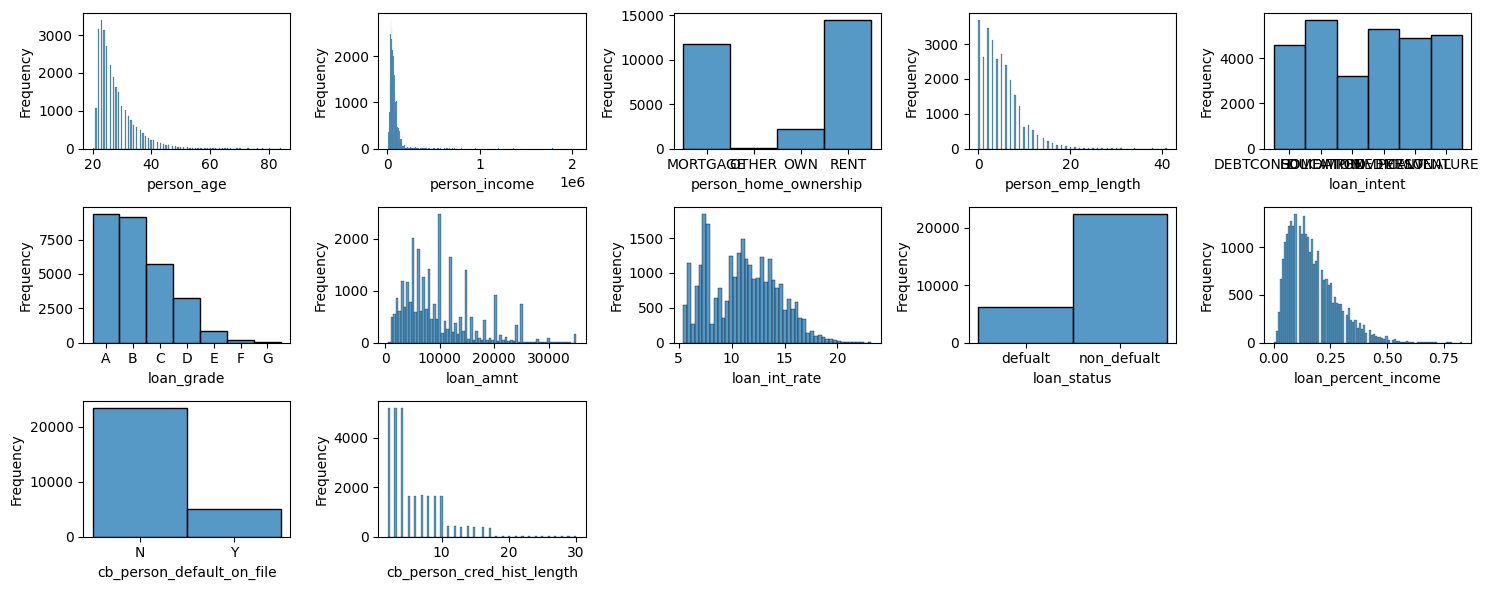

In [8]:
import matplotlib.pyplot as plt 
import seaborn as sns

fig, axes = plt.subplots(len(df.columns)//4, 5, figsize=(15, 6))
axes = axes.flatten()
for i, col in enumerate(df.columns):
    # if df[col].dtype != 'category':
    sns.histplot(df[col], ax=axes[i])
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")
    
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

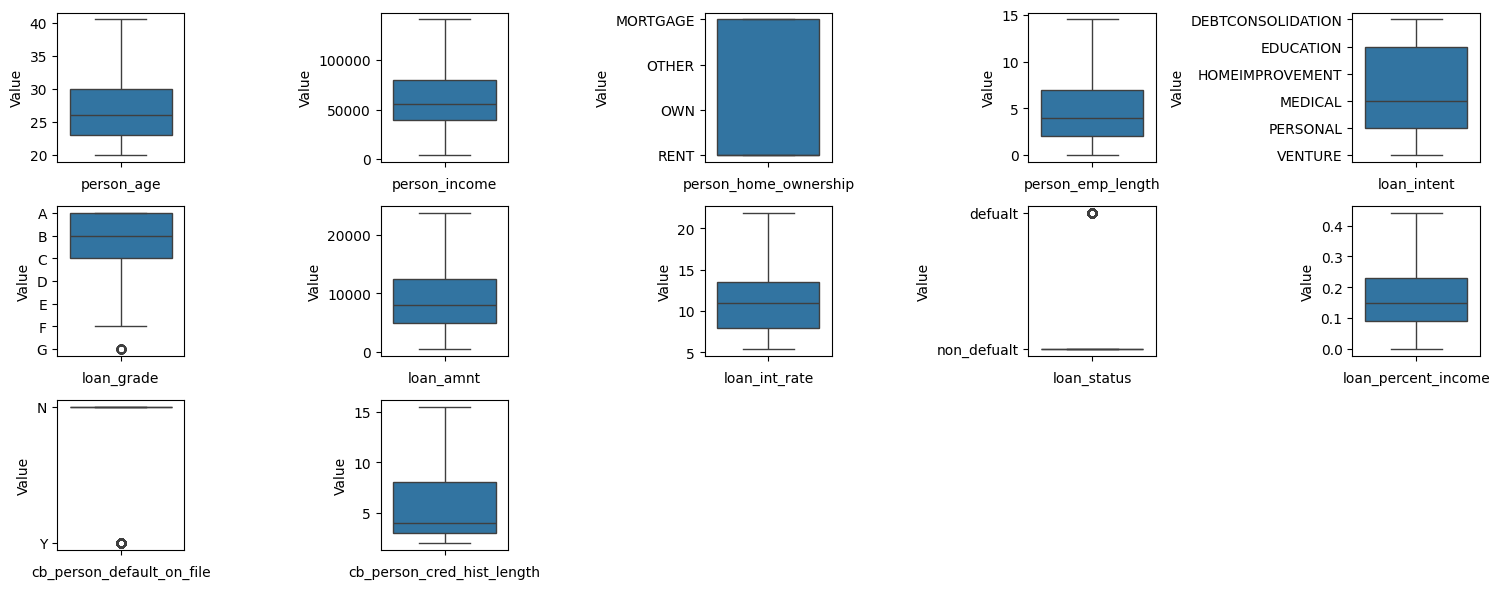

In [15]:
fig, axes = plt.subplots(len(clean_df.columns)//4, 5, figsize=(15, 6))
axes = axes.flatten()
for i, col in enumerate(clean_df.columns):
    sns.boxplot(clean_df[col], ax=axes[i])
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Value")

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [18]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

num_cols = [
    'person_age', 'person_income', 'person_emp_length',
    'loan_amnt', 'loan_int_rate',
    'loan_percent_income', 'cb_person_cred_hist_length'
]

cat_cols = [
    'person_home_ownership',
    'loan_intent',
    'loan_grade',
    'loan_status',
    'cb_person_default_on_file'
]

results = []

for num in num_cols:
    for cat in cat_cols:
        model = ols(f'{num} ~ C({cat})', data=clean_df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)

        eta_sq = anova_table['sum_sq'][f'C({cat})'] / anova_table['sum_sq'].sum()
        
        p_value = anova_table['PR(>F)'][f'C({cat})']

        results.append({
            'Numeric_Var': num,
            'Categorical_Var': cat,
            'Eta_Squared': eta_sq,
            'p_value': p_value
        })

eta_df = pd.DataFrame(results)
eta_df.sort_values(by='Eta_Squared', ascending=False)


,Numeric_Var,Categorical_Var,Eta_Squared,p_value
22,loan_int_rate,loan_grade,0.902830,0.000000e+00
24,loan_int_rate,cb_person_default_on_file,0.250220,0.000000e+00
28,loan_percent_income,loan_status,0.142729,0.000000e+00
23,loan_int_rate,loan_status,0.115117,0.000000e+00
5,person_income,person_home_ownership,0.108406,0.000000e+00
10,person_emp_length,person_home_ownership,0.063298,0.000000e+00
8,person_income,loan_status,0.057058,0.000000e+00
17,loan_amnt,loan_grade,0.033370,1.256493e-206
25,loan_percent_income,person_home_ownership,0.021415,5.267232e-134
27,loan_percent_income,loan_grade,0.020005,1.013014e-121


#### Example: η² = 0.21 → loan_grade explains 21% of variance in loan_amnt
Anova measures how much variance in a numerical variable is explained by a categorical variable
| Condition | Interpretation                |
| --------- | ----------------------------- |
| p < 0.05  | Significant relationship      |
| p ≥ 0.05  | Not statistically significant |


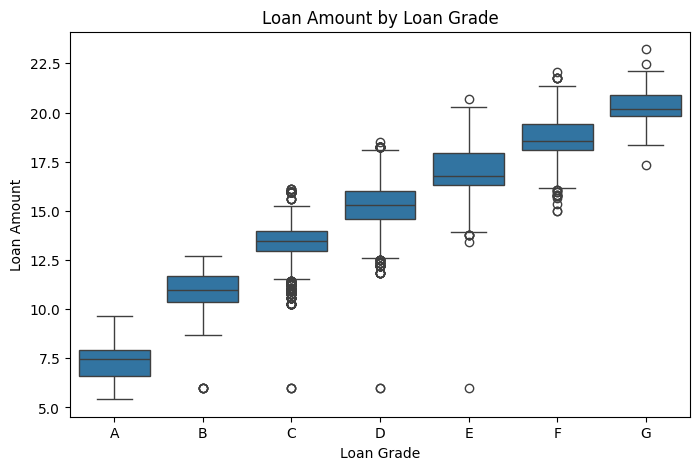

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(x='loan_grade', y='loan_int_rate', data=df)
plt.title('Loan Amount by Loan Grade')
plt.xlabel('Loan Grade')
plt.ylabel('Loan Amount')
plt.show()

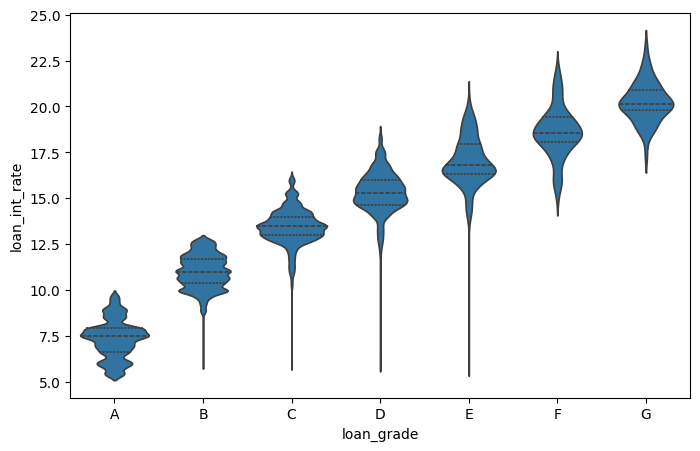

In [41]:
plt.figure(figsize=(8,5))
sns.violinplot(x='loan_grade', y='loan_int_rate', data=df, inner='quartile')
plt.show()

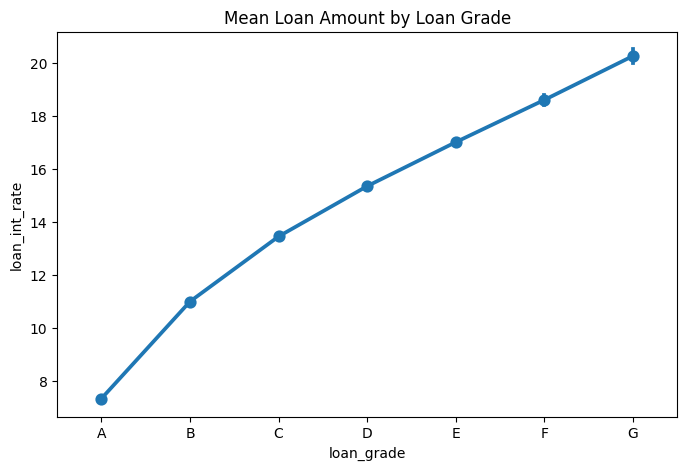

In [42]:
plt.figure(figsize=(8,5))
sns.pointplot(x='loan_grade', y='loan_int_rate', data=df, errorbar='ci')
plt.title('Mean Loan Amount by Loan Grade')
plt.show()

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = [
    'person_age', 'person_income', 'person_emp_length',
    'loan_amnt', 'loan_int_rate',
    'loan_percent_income', 'cb_person_cred_hist_length'
]

cat_cols = [
    'person_home_ownership',
    'loan_intent',
    'loan_grade',
    'loan_status',
    'cb_person_default_on_file'
]

In [9]:
# fig, axes = plt.subplots(
#     nrows=len(num_cols),
#     ncols=len(cat_cols),
#     figsize=(4 * len(cat_cols), 3 * len(num_cols)),
#     constrained_layout=True
# )

# for i, num in enumerate(num_cols):
#     for j, cat in enumerate(cat_cols):
#         sns.violinplot(
#             x=cat,
#             y=num,
#             data=df,
#             ax=axes[i, j],
#             inner='quartile',
#             cut=0
#         )
#         axes[i, j].set_title(f'{num} vs {cat}', fontsize=9)
#         axes[i, j].tick_params(axis='x', rotation=45)

# plt.show()

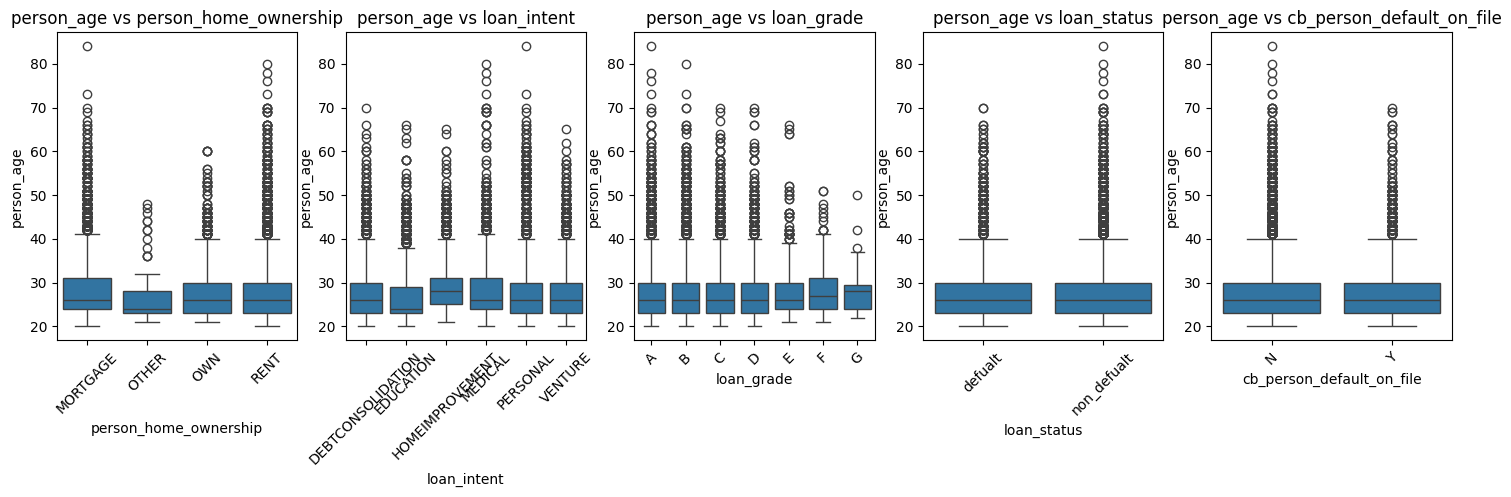

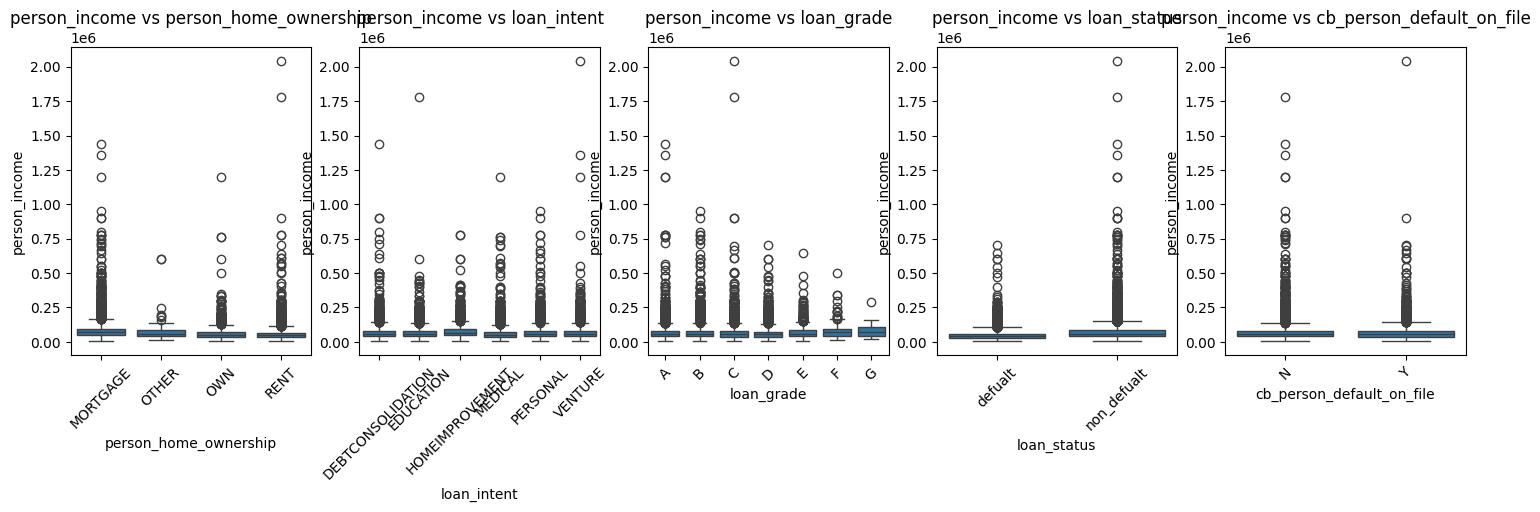

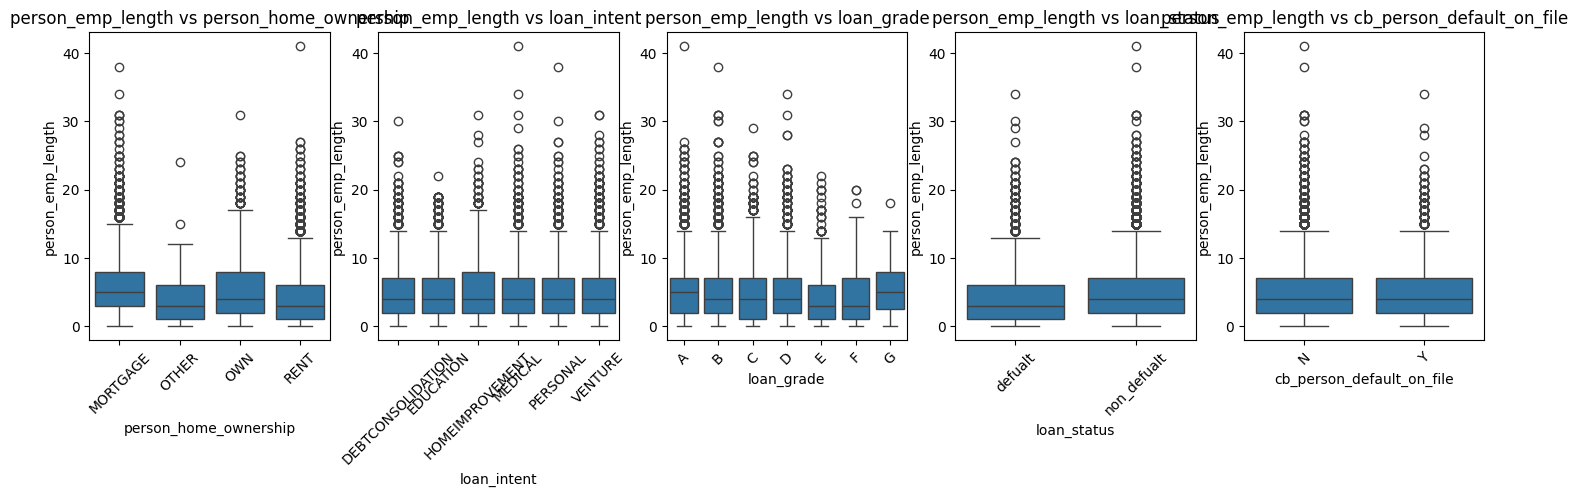

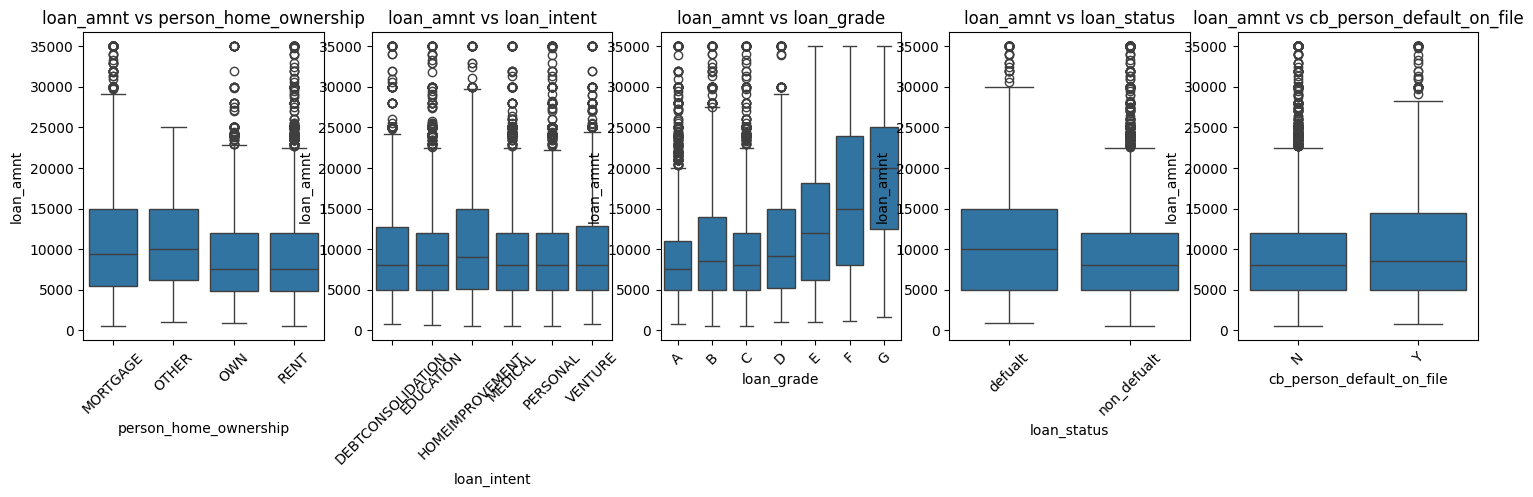

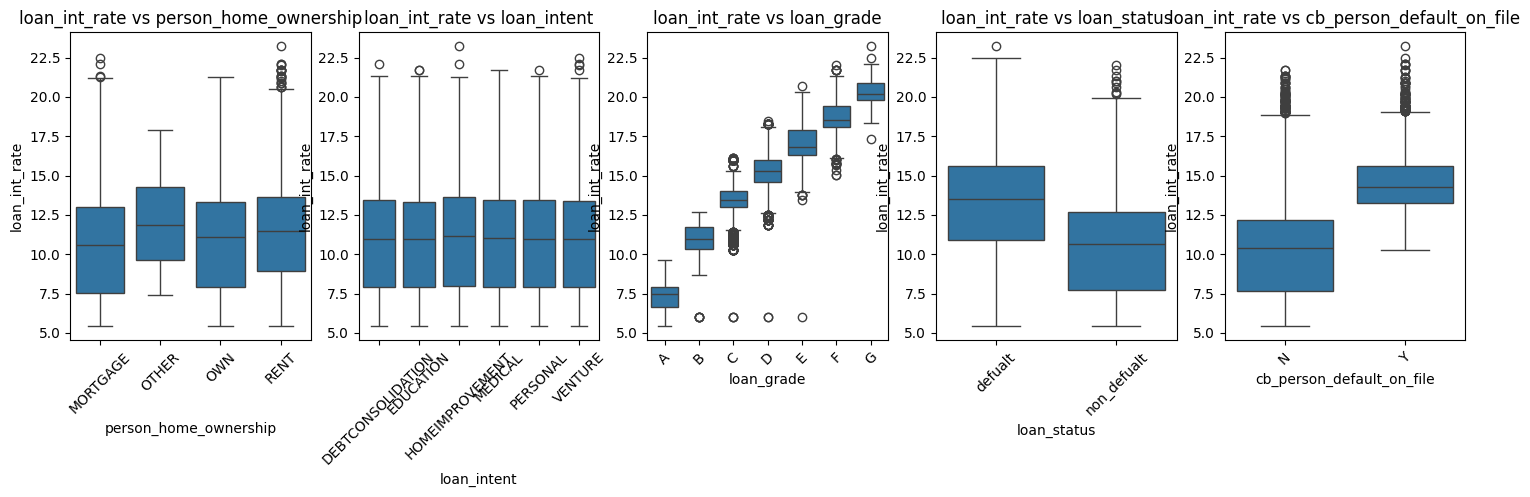

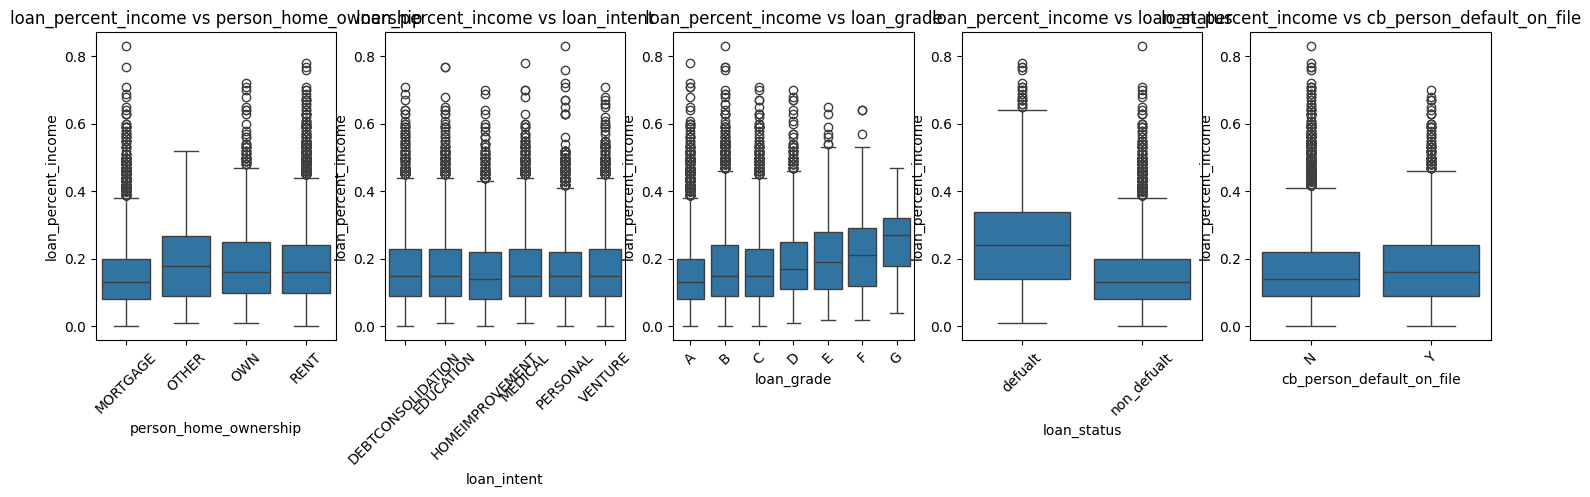

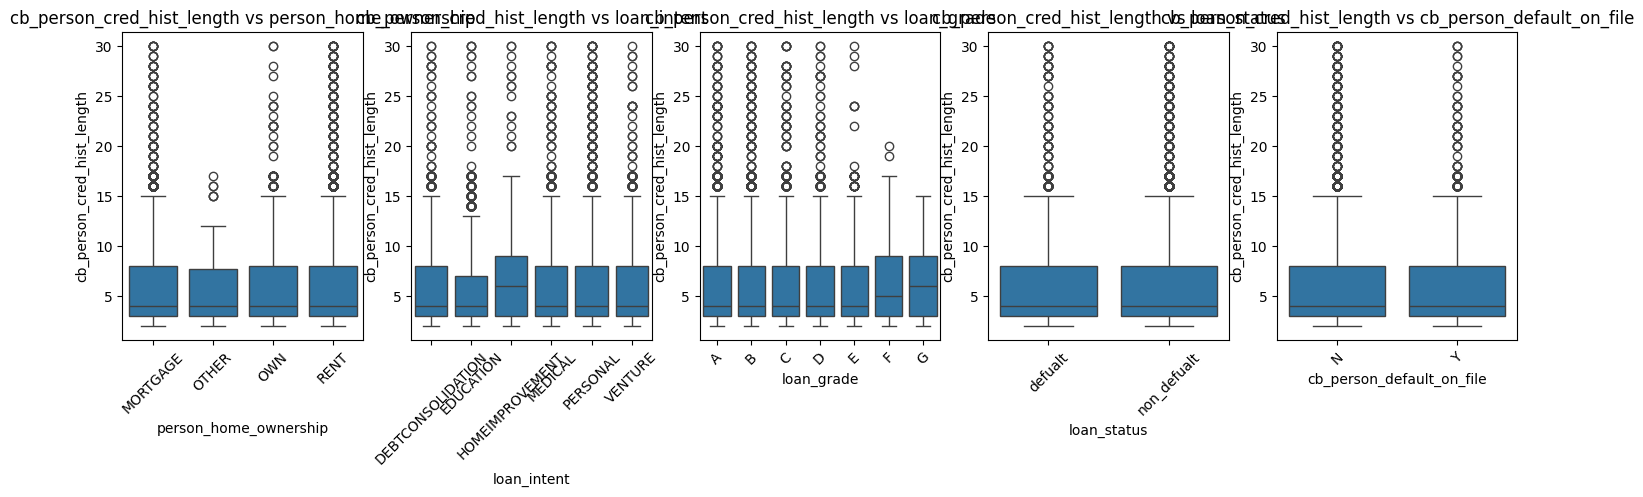

In [34]:
for num in num_cols:
    fig, axes = plt.subplots(1, len(cat_cols), figsize=(18,4))
    for j, cat in enumerate(cat_cols):
        sns.boxplot(x=cat, y=num, data=df, ax=axes[j])
        axes[j].set_title(f'{num} vs {cat}')
        axes[j].tick_params(axis='x', rotation=45)
    plt.show()


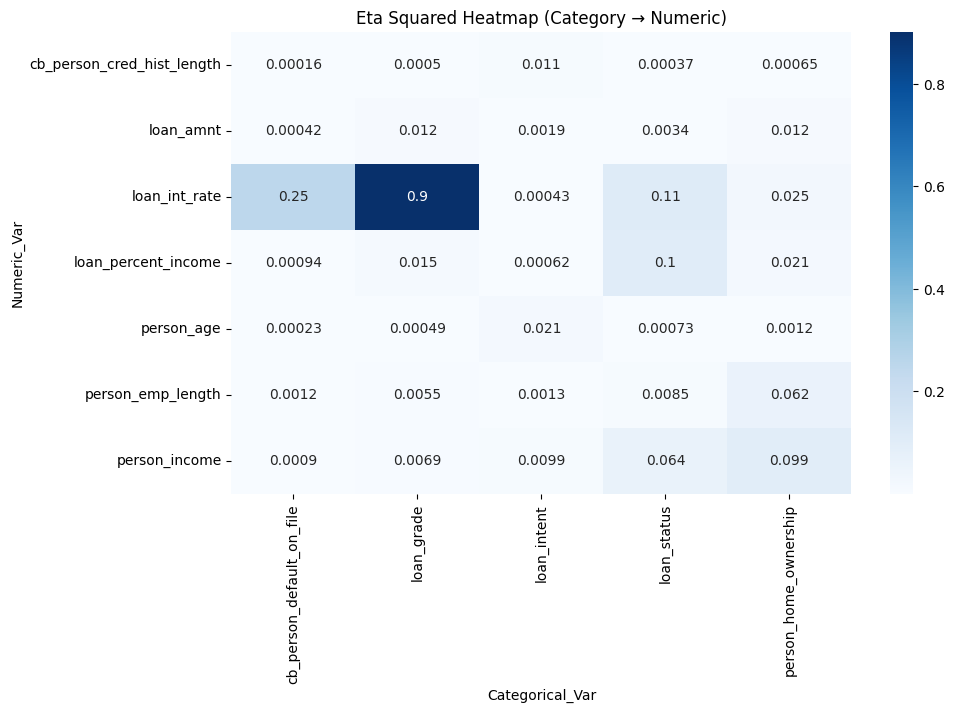

In [30]:
eta_pivot = eta_df.pivot(
    index='Numeric_Var',
    columns='Categorical_Var',
    values='Eta_Squared'
)

plt.figure(figsize=(10,6))
sns.heatmap(eta_pivot, annot=True, cmap='Blues')
plt.title('Eta Squared Heatmap (Category → Numeric)')
plt.show()


In [18]:
num_cols = clean_df.select_dtypes(include=['int64', 'float64']).columns
type(num_cols)

pandas.core.indexes.base.Index

In [23]:
clean_df.shape

(28632, 12)

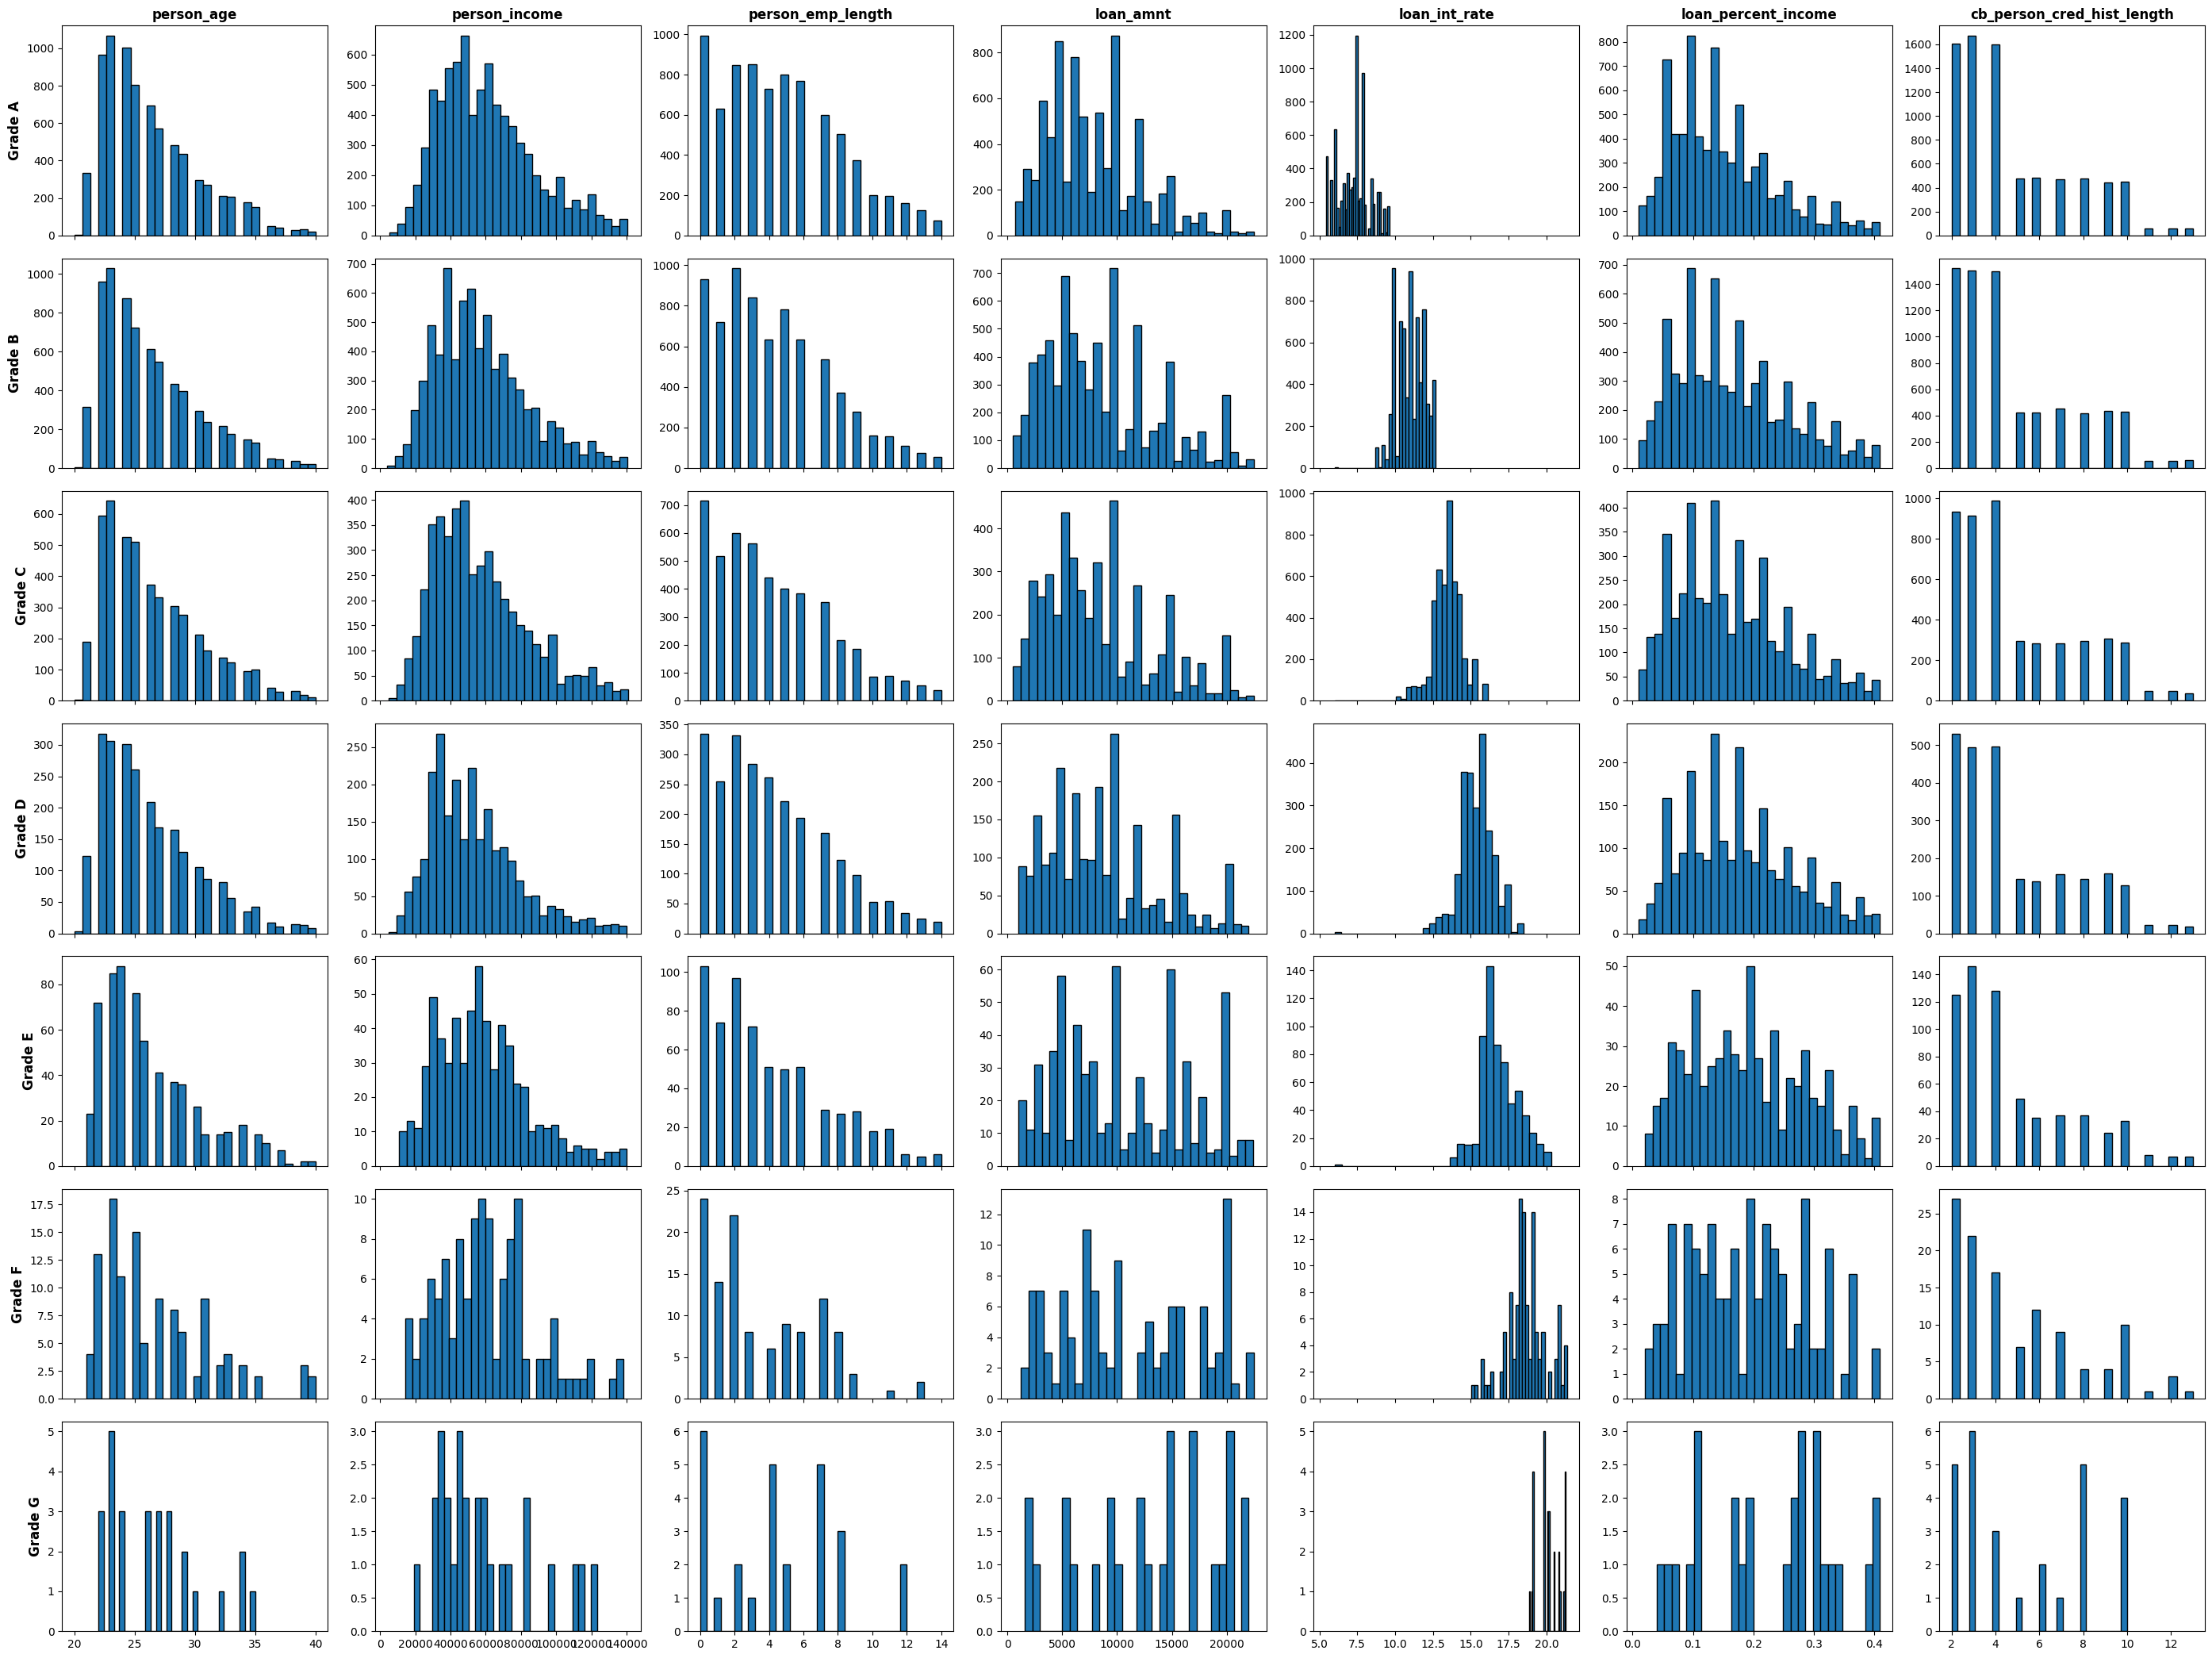

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = clean_df.select_dtypes(include=['int64', 'float64']).columns
# all_cols = list(num_cols) + list(cat_cols)

group_col = 'loan_grade'   
groups = sorted(clean_df[group_col].unique())

n_groups = len(groups)
n_features = len(num_cols)

fig, axes = plt.subplots(
    n_groups,
    n_features,
    figsize=(4 * n_features, 3 * n_groups),
    sharex='col'
)

for row_idx, grade in enumerate(groups):
    df_group = clean_df[clean_df[group_col] == grade]

    for col_idx, feature in enumerate(num_cols):
        ax = axes[row_idx, col_idx] if n_groups > 1 else axes[col_idx]

        ax.hist(
            df_group[feature],
            bins=30,
            edgecolor='black'
        )

        # Titles (top row)
        if row_idx == 0:
            ax.set_title(feature, fontsize=12, fontweight='bold')

        # Row labels (left column)
        if col_idx == 0:
            ax.set_ylabel(f'Grade {grade}', fontsize=12, fontweight='bold')
        else:
            ax.set_ylabel('')

        # Clean x-labels except bottom row
        if row_idx < n_groups - 1:
            ax.set_xlabel('')

plt.tight_layout()
plt.show()


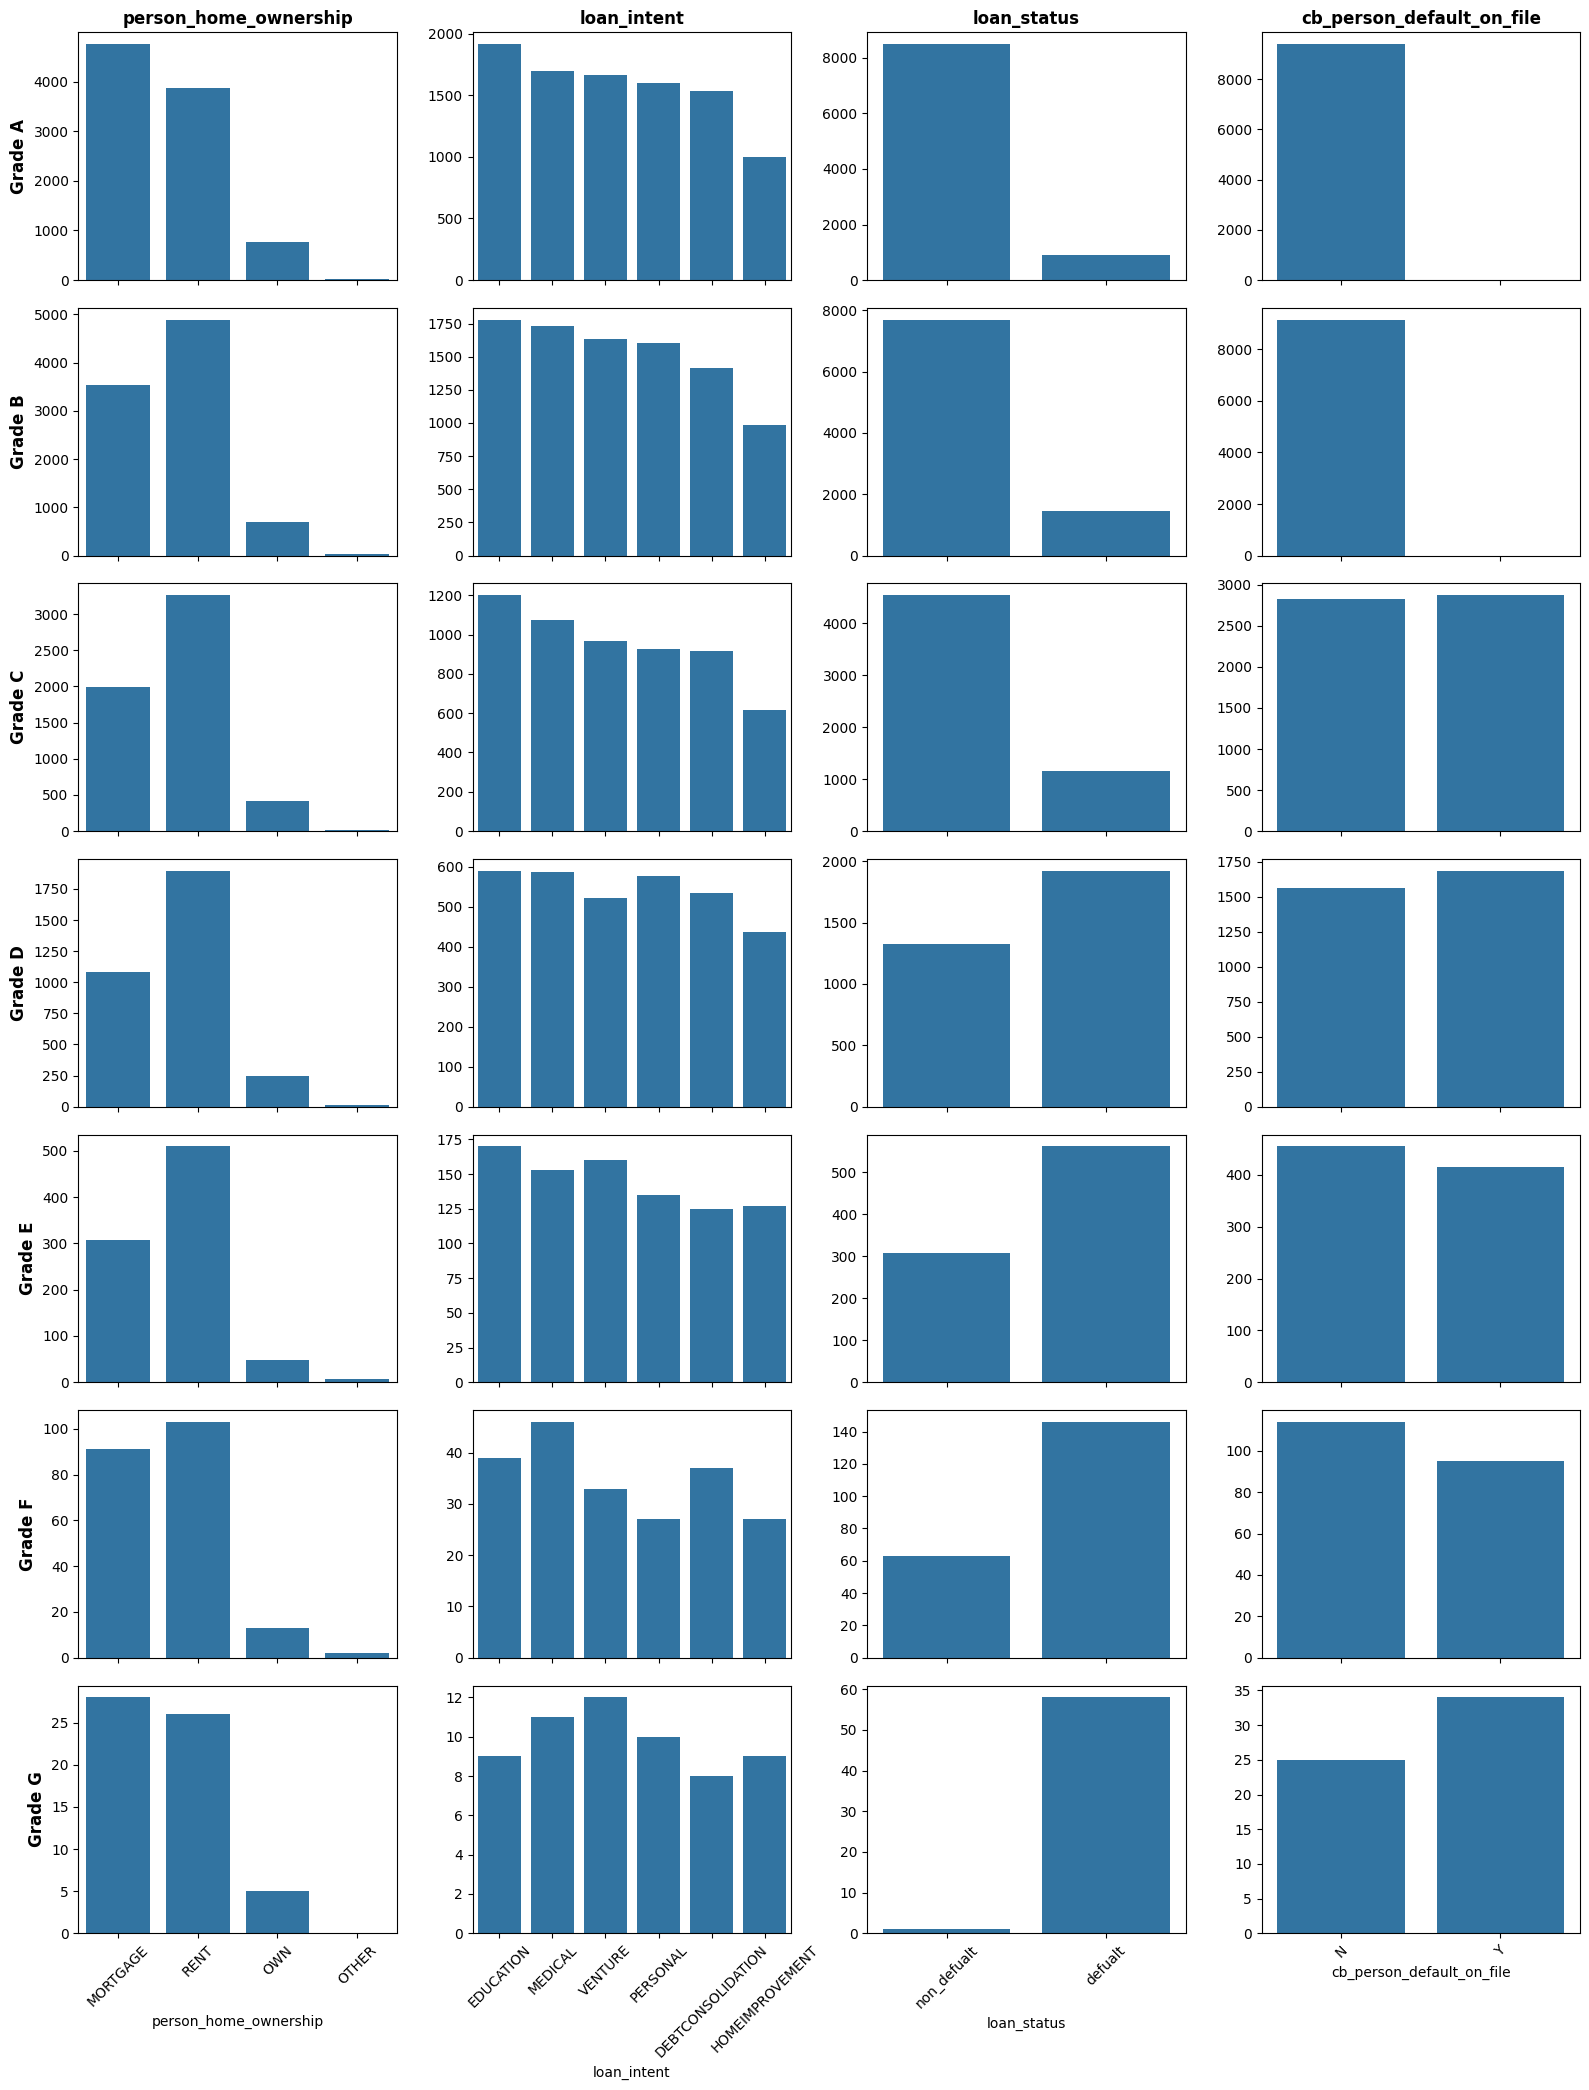

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

cat_cols = clean_df.select_dtypes(include=['object', 'category']).columns
cat_cols = cat_cols.drop('loan_grade')

group_col = 'loan_grade'   
groups = sorted(clean_df[group_col].unique())

n_groups = len(groups)
n_features = len(cat_cols)

fig, axes = plt.subplots(
    n_groups,
    n_features,
    figsize=(4 * n_features, 3 * n_groups),
    sharex='col'
    # sharey=
)

for row_idx, grade in enumerate(groups):
    df_group = clean_df[clean_df[group_col] == grade]

    for col_idx, feature in enumerate(cat_cols):
        ax = axes[row_idx, col_idx] if n_groups > 1 else axes[col_idx]

        sns.countplot(
            x=feature,
            data=df_group,
            ax=ax,
            order=df_group[feature].value_counts().index
        )
        ax.tick_params(axis='x', rotation=45)


        # Titles (top row)
        if row_idx == 0:
            ax.set_title(feature, fontsize=12, fontweight='bold')

        # Row labels (left column)
        if col_idx == 0:
            ax.set_ylabel(f'Grade {grade}', fontsize=12, fontweight='bold')
        else:
            ax.set_ylabel('')

        # Clean x-labels except bottom row
        if row_idx < n_groups - 1:
            ax.set_xlabel('')

plt.tight_layout()
plt.show()